# Thesis Code Part 1: EDA

## Import Packages

In [1]:
# Import packages
import numpy as np
import pandas as pd
import re
#import pydicom as dcm
from PIL import Image
import matplotlib.pyplot as plt

## UCSF CXR Dataset EDA
### Read report data

In [2]:
# Read report data
data = pd.read_csv('/mnt/sohn2022/UCSF_secure_cxr_data/Secure_UCSF_CXR_01012022_to_02132023.csv',index_col=0)
data = data.iloc[:,:13]
data.head()

,Organization,Point of Care,Source System,Accession Number,Modality,Exam Code,Exam Description,CPT Code,Report Text,Is Stat,Patient Status,Patient Sex,Patient Age
0,MBXR1,RAD X-RAY MB,EPIC,10022207761,XR,DCHE2,XR CHEST 2 VIEWS PA AND LATERAL,71020,XR CHEST 2 VIEWS PA AND LATERAL 6/30/2022 11...,False,Emergency,Male,39.00
1,PDR11,RAD X-RAY PARN,EPIC,10022207760,XR,DCHE1,XR CHEST 1 VIEW AP,71010,XR CHEST 1 VIEW AP 6/30/2022 11:53 PM\nHISTO...,False,Emergency,Male,41.00
2,PDR9,RAD X-RAY PARN,EPIC,10022207745,XR,DCHE1,XR CHEST 1 VIEW AP,71010,XR CHEST 1 VIEW AP 6/30/2022 11:36 PM\nHISTO...,False,Inpatient,Female,25.00
3,PDR9,RAD X-RAY PARN,EPIC,10022207747,XR,DCHE1,XR CHEST 1 VIEW AP,71010,XR CHEST 1 VIEW AP 6/30/2022 11:26 PM\nHISTO...,False,Inpatient,Female,60.00
4,MBP9,RAD X-RAY MB,EPIC,10022207748,XR,DCHE1,XR CHEST 1 VIEW AP,71010,XR CHEST 1 VIEW AP 6/30/2022 11:21 PM\nINDIC...,False,Inpatient,Female,0.27


### An example of report text and image

In [3]:
# Show an example of report text
data['Report Text'].sample(1).values[0]

'XR CHEST 1 VIEW AP   12/16/2022 7:35 AM\nINDICATION: Age:  11 months Gender:  Female. History:  eval lung inflation\nCOMPARISON: December 16, 2022 at 5:23 AM.\n\nHardware: \nNo change in tubes and lines positioning.\nLungs and pleural space: \nMild worsening within the left midlung and right upper lobe of previously seen perihilar hazy and patchy opacities\nHeart and mediastinum:\nStable normal cardiomediastinal silhouette.\nUpper abdomen: \nUnremarkable.\nBones: \nUnremarkable.\nSubcutaneous:\nUnremarkable.\n \nReport dictated by: Pierre-Alain Cohen, MD, signed by: Pierre-Alain Cohen, MD\nDepartment of Radiology and Biomedical Imaging'

In [4]:
# Show an example of chest x-ray image


### Reports that need further communication

In [5]:
# An example of report text that contains urgent findings
keywords = ['discuss','call','consult','communicate','request']
comm = data[data['Report Text'].str.contains('communicate|discuss|call|consult|request')]
comm['Report Text'].sample(1).values[0]

'XR CHEST 1 VIEW AP   9/22/2022 7:36 PM\nHISTORY: hypoxia\nCOMPARISON: Chest x-ray 3/28/2022\n\nFINDINGS/IMPRESSION:\nPatchy and interstitial opacities, most notably in the peripheral mid to upper lung, are new from prior examination; findings nonspecific but suspicious for infection, such as viral. No pneumothorax.\nUnchanged mediastinal silhouette.\n//Change to preliminary report was discussed with NP Anderson by Dr. Schroeder  (Radiology) on 9/23/2022 11:35 AM.//\nReport dictated by: Michael Khanjyan, MD, signed by: Jamie L Schroeder\nDepartment of Radiology and Biomedical Imaging'

### Distribution of labels

False    99841
True      1526
Name: label, dtype: int64


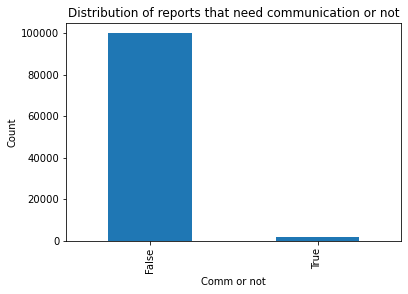

0.02%  of reports need further communication


In [6]:
data['label'] = data['Report Text'].str.contains('communicate|discuss')
value_counts = data['label'].value_counts()
print(value_counts)
value_counts.plot(kind='bar')
plt.xlabel('Comm or not')
plt.ylabel('Count')
plt.title('Distribution of reports that need communication or not')
plt.show()

dist = dict(value_counts)
percent = dist[True]/(dist[True]+dist[False])
print("{:.2f}%".format(percent),' of reports need further communication')

In [7]:
# Other factors - Age
print("Average patient age for those don't need further communication is:",np.mean(data[data['label']==False]['Patient Age']),
      "and average age for those that need communication is:",np.mean(data[data['label']==True]['Patient Age']))

Average patient age for those don't need further communication is: 44.72650975050174 and average age for those that need communication is: 46.5365137614679


In [8]:
# Other factors - Sex, Patient Status
sex = dict(data[data['label']==True]['Patient Sex'].value_counts())
status = dict(data[data['label']==True]['Patient Status'].value_counts())
print('Amon patients whose radiology report need further communication,', sex['Male']/263, 'are male, and',
     sex['Female']/263,'are female;',status['Inpatient']/263, 'are inpatient.')

Amon patients whose radiology report need further communication, 3.2395437262357416 are male, and 2.55893536121673 are female; 4.258555133079848 are inpatient.


## Preprocessing
### Extract findings

In [9]:
# functions from Adrian
def preprocess_findings(report_text):     
    findings_impression = re.search(r"((?<=\nFINDINGS\/IMPRESSION:|FINDINGS\/IMPRESSION:\n)(.|\n)*)", report_text)
    if findings_impression:
        findings_impression = findings_impression.group(0).split('"')[0]
        findings_impression = re.sub(r"(?=(Impression discussed|Further impression|Final impression|Attestation|Radiologist|Electronically|This change was|Report dictated))(.|\n)*", "", findings_impression)
        return findings_impression.strip()
    return 'None'

In [10]:
data['Findings'] = data['Report Text'].apply(preprocess_findings)
data.head()

,Organization,Point of Care,Source System,Accession Number,Modality,Exam Code,Exam Description,CPT Code,Report Text,Is Stat,Patient Status,Patient Sex,Patient Age,label,Findings
0,MBXR1,RAD X-RAY MB,EPIC,10022207761,XR,DCHE2,XR CHEST 2 VIEWS PA AND LATERAL,71020,XR CHEST 2 VIEWS PA AND LATERAL 6/30/2022 11...,False,Emergency,Male,39.00,False,Clear lungs. No pleural effusion or pneumothor...
1,PDR11,RAD X-RAY PARN,EPIC,10022207760,XR,DCHE1,XR CHEST 1 VIEW AP,71010,XR CHEST 1 VIEW AP 6/30/2022 11:53 PM\nHISTO...,False,Emergency,Male,41.00,False,Increased right greater than left opacities ma...
2,PDR9,RAD X-RAY PARN,EPIC,10022207745,XR,DCHE1,XR CHEST 1 VIEW AP,71010,XR CHEST 1 VIEW AP 6/30/2022 11:36 PM\nHISTO...,False,Inpatient,Female,25.00,False,Endotracheal tube terminates approximately 5 c...
3,PDR9,RAD X-RAY PARN,EPIC,10022207747,XR,DCHE1,XR CHEST 1 VIEW AP,71010,XR CHEST 1 VIEW AP 6/30/2022 11:26 PM\nHISTO...,False,Inpatient,Female,60.00,False,Right chest wall port appears unchanged.\nNo s...
4,MBP9,RAD X-RAY MB,EPIC,10022207748,XR,DCHE1,XR CHEST 1 VIEW AP,71010,XR CHEST 1 VIEW AP 6/30/2022 11:21 PM\nINDIC...,False,Inpatient,Female,0.27,False,None


In [11]:
sample = data[data['label']==False].sample(2000)
data = pd.concat([sample,data[data['label']==True]])
data

,Organization,Point of Care,Source System,Accession Number,Modality,Exam Code,Exam Description,CPT Code,Report Text,Is Stat,Patient Status,Patient Sex,Patient Age,label,Findings
3096,PDR5,RAD X-RAY PARN,EPIC,10022173220,XR,DCHE1,XR CHEST 1 VIEW AP,71010,XR CHEST 1 VIEW AP 6/17/2022 9:35 AM\nHISTOR...,False,Inpatient,Male,23.00,False,Interval removal of previously seen right inte...
2861,PDR9,RAD X-RAY PARN,EPIC,10021932090,XR,DCHE1,XR CHEST 1 VIEW AP,71010,XR CHEST 1 VIEW AP 3/20/2022 8:08 AM\nHISTOR...,False,Inpatient,Male,63.00,False,Left pleural pigtail catheter in place with no...
9936,MBP6,RAD X-RAY MB,EPIC,10022647819,XR,DCHE1,XR CHEST 1 VIEW AP,71010,XR CHEST 1 VIEW AP 11/23/2022 3:30 AM\nINDIC...,False,Inpatient,Female,0.17,False,None
4021,A02,RAD X-RAY PARN MB1,EPIC,10022160882,XR,DCHE2,XR CHEST 2 VIEWS PA AND LATERAL,71020,XR CHEST 2 VIEWS PA AND LATERAL 6/13/2022 3:...,False,Outpatient,Male,65.00,False,Clear lungs. No pleural effusion or pneumothor...
6997,PDR5,RAD X-RAY PARN,EPIC,10022806959,XR,DCHE1,XR CHEST 1 VIEW AP,71010,XR CHEST 1 VIEW AP 1/17/2023 3:28 PM\nHISTOR...,False,Inpatient,Male,59.00,False,Interval intubation with tip terminating appro...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21408,PDR2,RAD X-RAY PARN,EPIC,10021724091,XR,DCHE1,XR CHEST 1 VIEW AP,71010,INDICATION:\nXR CHEST 1 VIEW AP 1/2/2022 5:0...,False,Inpatient,Male,51.00,True,New large right pneumothorax with associated c...
21496,PDR11,RAD X-RAY PARN,EPIC,10021723765,XR,DCHE1,XR CHEST 1 VIEW AP,71010,INDICATION:\nXR CHEST 1 VIEW AP 1/2/2022 7:5...,False,Inpatient,Male,74.00,True,Interval removal of enteric tube and right int...
21500,PDR1,RAD X-RAY PARN,EPIC,10021723758,XR,DCHE1,XR CHEST 1 VIEW AP,71010,INDICATION:\nXR CHEST 1 VIEW AP 1/2/2022 7:0...,False,Inpatient,Male,59.00,True,Right PICC with tip now flipped upwards extend...
21622,PDR12,RAD X-RAY PARN,EPIC,10021723415,XR,DCHE1,XR CHEST 1 VIEW AP,71010,INDICATION:\nXR CHEST 1 VIEW AP 1/1/2022 4:1...,False,Inpatient,Male,69.00,True,Significantly increased size of the now large ...


## Train Test Split

In [12]:
from sklearn.model_selection import train_test_split

# fix seed for reproducibility
np.random.seed(2023)

# split the dataset depending on whether we need a validation set
def split(reports_df, val=False):
    train, test = train_test_split(reports_df, test_size = 0.2, shuffle=True)
    if val:
        train, validation = train_test_split(train, test_size = 0.1, shuffle=True)
        return train, validation, test
    else:
        return train, test

train,test = split(data,val=False)

In [13]:
train.to_csv('train.csv')
test.to_csv('test.csv')